# 1.0 Framing the problem: Predicting Passing Yards

The core challenge addressed in this project is to forecast the passing yards achieved on an individual play within NFL games. Accurate predictions of passing yards are crucial for NFL coaches as they can significantly influence play-calling decisions, particularly in real-time during games. For instance, understanding whether a blitz is likely to suppress or enhance a quarterback's passing yards can directly inform defensive strategies.

For NFL coaches, predicting play outcomes is not just about adjusting defensive formations; it's about gaining an edge in the highly strategic environment of professional football. They can use these insights to inform their preparation, identifying which factors most strongly contribute to successful pass defense and which may signal vulnerabilities.

By leveraging detailed play-by-play data, this project aims to provide a granular analysis that goes beyond traditional statistics. We explore how different variables—ranging from player positions and field location to the specific actions taken pre-snap—can interact to affect the outcome of a passing play. Additionally, we investigate the Average Treatment Effect (ATE) of defensive blitzes on passing yards, offering a novel perspective on conventional football wisdom.

In this pursuit, we address potential data limitations by seeking supplemental datasets that enhance the robustness of our predictions. Our goal is to achieve a model that not only predicts with high accuracy but also withstands the scrutiny of various stakeholders, including coaches, who rely on precise and actionable insights to make informed decisions during the heat of competition.

The project reaches its conclusion when we can consistently predict passing yards within a tight margin of error, providing NFL teams with a strategic tool that is both reliable and practical in a live game setting. Should our initial results leave room for improvement, we are prepared to iterate on our model by incorporating more nuanced data to refine our predictions further.

### Import Packages

In [ ]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.inference.tf import DragonNet
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset.regression import *
from causalml.metrics import *

import os, sys

%matplotlib inline

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
sns.set_palette('Paired')
plt.rcParams['figure.figsize'] = (12,8)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


In [ ]:
file_path =  path + "plays.csv"
plays = pd.read_csv(file_path)

In [4]:
pd.set_option('display.max_colwidth', None)
data_dict = pd.read_excel(path+"NFL_passing_dict.xlsx")

data_dict

,Column,Definition
0,gameId,A unique identifier for each game.
1,playId,A unique identifier for each play within a game.
2,playDescription,A description of the play that was executed.
3,quarter,"quarter: The quarter in which the play took place (1st, 2nd, 3rd, or 4th)."
4,down,"The down (1st, 2nd, 3rd, or 4th) for the current play."
5,yardsToGo,The number of yards that the offense must gain for a first down.
6,possessionTeam,The team that is in possession of the ball.
7,playType,The type of play that was executed (only passing plays).
8,yardlineSide,The side of the field where the ball is located (home or awayor right).
9,yardlineNumber,The yardline number where the ball is located


## **1.1 Data Aquisition/Data Cleaning**

In [ ]:
plays.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,...,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,...,0.0,15:00:00,90.0,NaN,NaN,C,10,10,0.261827,False
1,2018090600,146,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,ATL,play_type_pass,PHI,39,...,0.0,13:10:00,49.0,NaN,NaN,I,0,0,-0.372360,False
2,2018090600,168,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,ATL,play_type_pass,PHI,39,...,0.0,13:05:00,49.0,NaN,NaN,I,0,0,-0.702779,False
3,2018090600,190,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,ATL,play_type_pass,PHI,39,...,0.0,13:01:00,49.0,NaN,NaN,C,33,33,3.047530,False
4,2018090600,256,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,ATL,play_type_pass,PHI,1,...,0.0,10:59:00,11.0,NaN,NaN,I,0,0,-0.842272,False


In [ ]:
def ProcessPlays(df):

    if 'Blitz'in df:
        return df

    #Categorize if it is a blitz
    df['Blitz'] = np.where(df['numberOfPassRushers']>4, 1,0)

    #Personnel
    df.dropna(subset=['personnelO','personnelD'])  #lot of missing records in the end

    #Offense Team Formation using 'personnelO' column
    temp = df['personnelO'].str.split(',',n = 2, expand = True)
    df['Off_RB'] = temp[0].str.split(' ',n = 1, expand = True)[0]
    df['Off_TE'] = temp[1].str.split(' ',n = 2, expand = True)[1]
    df['Off_WR'] = temp[2].str.split(' ',n = 2, expand = True)[1]

    #Defense Team Formation using 'personnelD' column
    temp2 = df['personnelD'].str.split(',',n = 2, expand = True)
    df['Def_DL'] = temp2[0].str.split(' ',n = 1, expand = True)[0]
    df['Def_LB'] = temp2[1].str.split(' ',n = 2, expand = True)[1]
    df['Def_DB'] = temp2[2].str.split(' ',n = 2, expand = True)[1]

    return df

plays = ProcessPlays(plays)

plays

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,...,playResult,epa,isDefensivePI,Blitz,Off_RB,Off_TE,Off_WR,Def_DL,Def_LB,Def_DB
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,...,10,0.261827,False,0,2,1,2,4,2,5
1,2018090600,146,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,ATL,play_type_pass,PHI,39,...,0,-0.372360,False,0,1,1,3,4,2,5
2,2018090600,168,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,ATL,play_type_pass,PHI,39,...,0,-0.702779,False,0,2,1,2,4,2,5
3,2018090600,190,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,ATL,play_type_pass,PHI,39,...,33,3.047530,False,1,1,1,3,4,1,6
4,2018090600,256,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,ATL,play_type_pass,PHI,1,...,0,-0.842272,False,1,2,3,0,6,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19234,2018122200,2300,(7:53) J.Johnson pass incomplete short left [K...,3,2,5,WAS,play_type_unknown,WAS,31,...,5,0.848703,False,0,1,1,3,2,4,5
19235,2018122200,3177,(6:53) (Shotgun) B.Gabbert pass incomplete sho...,4,3,7,TEN,play_type_unknown,WAS,37,...,5,1.227695,False,0,1,1,3,2,4,5
19236,2018122201,566,(5:32) (Shotgun) P.Rivers pass deep right to K...,1,3,4,LAC,play_type_unknown,LAC,49,...,-10,-0.720168,False,0,1,1,3,1,5,5
19237,2018122201,1719,(1:08) P.Rivers pass incomplete deep middle to...,2,3,1,LAC,play_type_unknown,LAC,48,...,15,1.336078,True,0,1,1,3,2,3,6


In [ ]:
plays = plays.drop(['gameId','playId','playDescription','playType','yardlineSide','yardlineNumber','personnelO','personnelD','penaltyCodes','penaltyJerseyNumbers'],axis = 1)

In [ ]:
plays = plays.drop(['isDefensivePI'],axis=1)

In [ ]:
plays['score_diff'] = plays['preSnapVisitorScore'] - plays['preSnapHomeScore']

In [ ]:
plays = plays.drop(['preSnapVisitorScore','preSnapHomeScore','epa', 'passResult', 'playResult'], axis = 1)

In [ ]:
plays = plays.drop(['gameClock'],axis=1)

In [ ]:
plays = pd.get_dummies(plays, columns=(['typeDropback']))

In [ ]:
plays = pd.get_dummies(plays,columns = (['offenseFormation']))

In [ ]:
nan_count = plays.isna().sum()
print(nan_count)

quarter                                  0
down                                     0
yardsToGo                                0
possessionTeam                           0
defendersInTheBox                       62
numberOfPassRushers                    633
absoluteYardlineNumber                 639
offensePlayResult                        0
Blitz                                    0
Off_RB                                  29
Off_TE                                  29
Off_WR                                  29
Def_DL                                  29
Def_LB                                  29
Def_DB                                  29
score_diff                             639
typeDropback_DESIGNED_ROLLOUT_LEFT       0
typeDropback_DESIGNED_ROLLOUT_RIGHT      0
typeDropback_SCRAMBLE                    0
typeDropback_SCRAMBLE_ROLLOUT_LEFT       0
typeDropback_SCRAMBLE_ROLLOUT_RIGHT      0
typeDropback_TRADITIONAL                 0
typeDropback_UNKNOWN                     0
offenseForm

In [ ]:
plays.dropna(how = "any", inplace = True)

In [ ]:
plays.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18584 entries, 0 to 18605
Data columns (total 30 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   quarter                              18584 non-null  int64  
 1   down                                 18584 non-null  int64  
 2   yardsToGo                            18584 non-null  int64  
 3   possessionTeam                       18584 non-null  object 
 4   defendersInTheBox                    18584 non-null  float64
 5   numberOfPassRushers                  18584 non-null  float64
 6   absoluteYardlineNumber               18584 non-null  float64
 7   offensePlayResult                    18584 non-null  int64  
 8   Blitz                                18584 non-null  int64  
 9   Off_RB                               18584 non-null  object 
 10  Off_TE                               18584 non-null  object 
 11  Off_WR                      

In [ ]:
plays['Off_RB'] = plays['Off_RB'].astype('int')
plays['Off_TE'] = plays['Off_TE'].astype('int')
plays['Off_WR'] = plays['Off_WR'].astype('int')

plays['Def_DL'] = plays['Def_DL'].astype('int')
plays['Def_LB'] = plays['Def_LB'].astype('int')
plays['Def_DB'] = plays['Def_DB'].astype('int')


In [ ]:
plays['typeDropback_TRADITIONAL'].sum()

15645

In [ ]:
plays.describe()

,quarter,down,yardsToGo,defendersInTheBox,numberOfPassRushers,absoluteYardlineNumber,offensePlayResult,Blitz,Off_RB,Off_TE,...,typeDropback_SCRAMBLE_ROLLOUT_RIGHT,typeDropback_TRADITIONAL,typeDropback_UNKNOWN,offenseFormation_EMPTY,offenseFormation_I_FORM,offenseFormation_JUMBO,offenseFormation_PISTOL,offenseFormation_SHOTGUN,offenseFormation_SINGLEBACK,offenseFormation_WILDCAT
count,18584.000000,18584.000000,18584.000000,18584.000000,18584.000000,18584.000000,18584.000000,18584.000000,18584.000000,18584.000000,...,18584.000000,18584.000000,18584.000000,18584.000000,18584.000000,18584.000000,18584.000000,18584.000000,18584.000000,18584.000000
mean,2.591100,1.915142,8.941724,6.032878,4.219651,59.898461,6.430854,0.271847,1.130811,1.177464,...,0.058975,0.841853,0.004359,0.126614,0.047837,0.002637,0.012914,0.658254,0.145663,0.001883
std,1.124154,0.845905,3.979809,1.016119,0.890779,23.642050,10.225886,0.444923,0.629718,0.492024,...,0.235585,0.364888,0.065877,0.332549,0.213427,0.051282,0.112908,0.474308,0.352777,0.043358
min,1.000000,1.000000,1.000000,1.000000,0.000000,11.000000,-19.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,7.000000,6.000000,4.000000,40.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2.000000,10.000000,6.000000,4.000000,60.000000,4.000000,0.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,4.000000,3.000000,10.000000,7.000000,5.000000,80.000000,10.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,5.000000,4.000000,41.000000,11.000000,10.000000,109.000000,97.000000,1.000000,6.000000,4.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## **1.2 Data Exploration**

In [ ]:
plays.head()

,quarter,down,yardsToGo,possessionTeam,defendersInTheBox,numberOfPassRushers,absoluteYardlineNumber,offensePlayResult,Blitz,Off_RB,...,typeDropback_SCRAMBLE_ROLLOUT_RIGHT,typeDropback_TRADITIONAL,typeDropback_UNKNOWN,offenseFormation_EMPTY,offenseFormation_I_FORM,offenseFormation_JUMBO,offenseFormation_PISTOL,offenseFormation_SHOTGUN,offenseFormation_SINGLEBACK,offenseFormation_WILDCAT
0,1,1,15,ATL,7.0,4.0,90.0,10,0,2,...,0,1,0,0,1,0,0,0,0,0
1,1,1,10,ATL,7.0,4.0,49.0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
2,1,2,10,ATL,6.0,4.0,49.0,0,0,2,...,0,1,0,0,0,0,0,1,0,0
3,1,3,10,ATL,6.0,5.0,49.0,33,1,1,...,0,0,0,0,0,0,0,1,0,0
4,1,3,1,ATL,8.0,6.0,11.0,0,1,2,...,0,1,0,0,0,0,0,1,0,0


In [ ]:
plays.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18584 entries, 0 to 18605
Data columns (total 30 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   quarter                              18584 non-null  int64  
 1   down                                 18584 non-null  int64  
 2   yardsToGo                            18584 non-null  int64  
 3   possessionTeam                       18584 non-null  object 
 4   defendersInTheBox                    18584 non-null  float64
 5   numberOfPassRushers                  18584 non-null  float64
 6   absoluteYardlineNumber               18584 non-null  float64
 7   offensePlayResult                    18584 non-null  int64  
 8   Blitz                                18584 non-null  int64  
 9   Off_RB                               18584 non-null  int64  
 10  Off_TE                               18584 non-null  int64  
 11  Off_WR                      

In [ ]:
off_formations = plays[['offenseFormation_EMPTY','offenseFormation_I_FORM', 'offenseFormation_JUMBO','offenseFormation_PISTOL','offenseFormation_SHOTGUN','offenseFormation_SINGLEBACK','offenseFormation_WILDCAT' ]]

In [ ]:
form_counts = off_formations.sum()

form_counts

offenseFormation_EMPTY          2353
offenseFormation_I_FORM          889
offenseFormation_JUMBO            49
offenseFormation_PISTOL          240
offenseFormation_SHOTGUN       12233
offenseFormation_SINGLEBACK     2707
offenseFormation_WILDCAT          35
dtype: int64

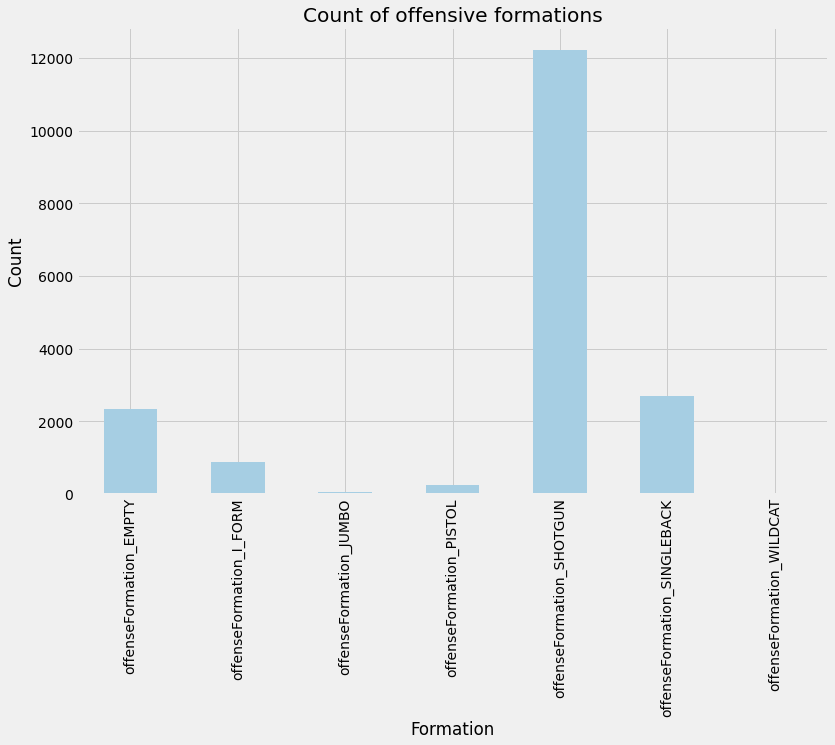

In [ ]:
import matplotlib.pyplot as plt
form_counts.plot(kind='bar')

# Add labels and title to the plot
plt.xlabel("Formation")
plt.ylabel("Count")
plt.title("Count of offensive formations")

# Show the plot
plt.show()

In [ ]:
dropbacks = plays[['typeDropback_DESIGNED_ROLLOUT_LEFT','typeDropback_DESIGNED_ROLLOUT_RIGHT','typeDropback_SCRAMBLE','typeDropback_SCRAMBLE_ROLLOUT_LEFT', 'typeDropback_SCRAMBLE_ROLLOUT_RIGHT','typeDropback_TRADITIONAL', 'typeDropback_UNKNOWN' ]]

In [ ]:
dropbacks_counts = dropbacks.sum()
dropbacks_counts

typeDropback_DESIGNED_ROLLOUT_LEFT       141
typeDropback_DESIGNED_ROLLOUT_RIGHT      482
typeDropback_SCRAMBLE                    677
typeDropback_SCRAMBLE_ROLLOUT_LEFT       462
typeDropback_SCRAMBLE_ROLLOUT_RIGHT     1096
typeDropback_TRADITIONAL               15645
typeDropback_UNKNOWN                      81
dtype: int64

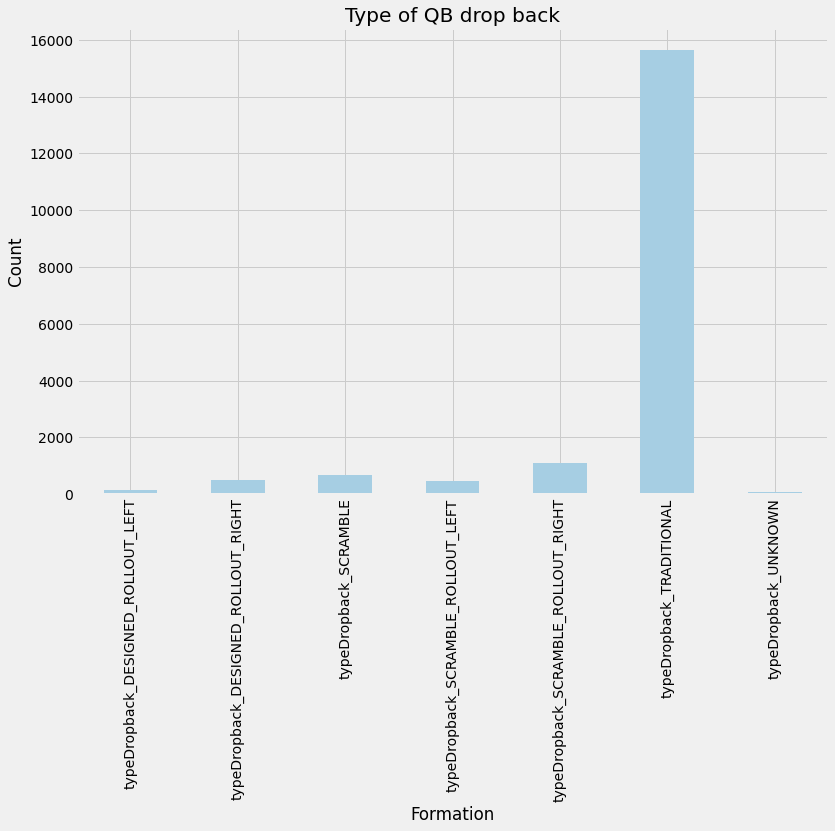

In [ ]:
dropbacks_counts.plot(kind='bar')

# Add labels and title to the plot
plt.xlabel("Formation")
plt.ylabel("Count")
plt.title("Type of QB drop back")

# Show the plot
plt.show()

In [ ]:
player_personel = plays[['Off_RB', 'Off_TE', 'Off_WR', 'Def_DL', 'Def_LB', 'Def_DB']]

player_personel_counts = player_personel.sum()

player_personel_counts

Off_RB    21015
Off_TE    21882
Off_WR    50718
Def_DL    61468
Def_LB    49432
Def_DB    93500
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb1390ec8e0>,
      dtype=object)

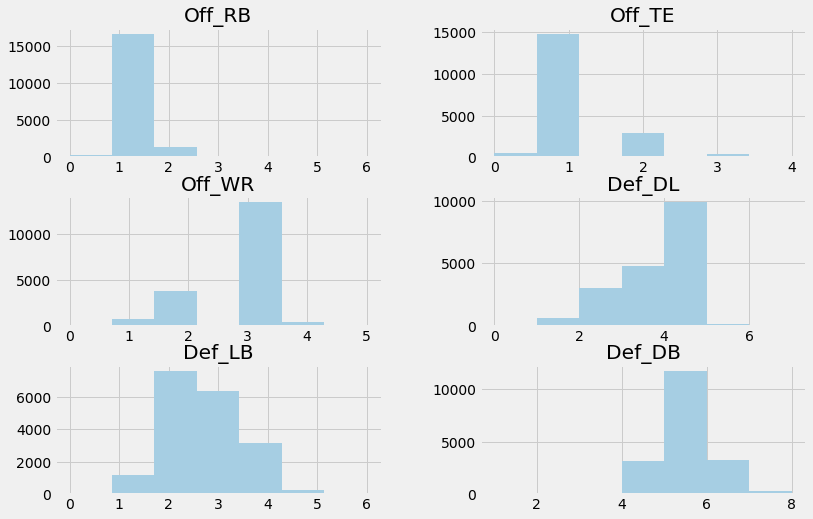

In [ ]:
player_personel.hist(bins=7, figsize=(12, 8))

In [ ]:
columns = plays.columns.tolist()

hist_cols = plays[['quarter', 'down', 'yardsToGo', 'defendersInTheBox', 'numberOfPassRushers', 'absoluteYardlineNumber', 'offensePlayResult', 'Blitz', 'score_diff']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb1390010a0>,
      dtype=object)

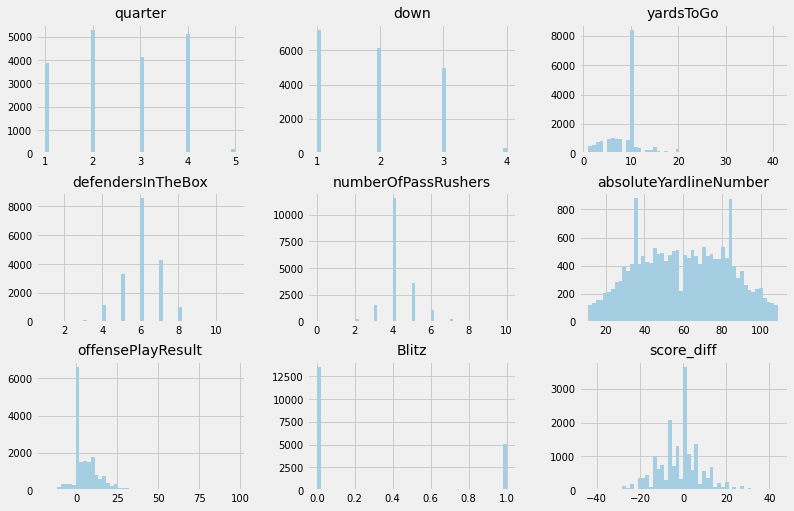

In [ ]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

hist_cols.hist(bins=50, figsize=(12, 8))

## **1.3 Data Preperation**

In [ ]:
columns

['quarter',
 'down',
 'yardsToGo',
 'possessionTeam',
 'defendersInTheBox',
 'numberOfPassRushers',
 'absoluteYardlineNumber',
 'offensePlayResult',
 'Blitz',
 'Off_RB',
 'Off_TE',
 'Off_WR',
 'Def_DL',
 'Def_LB',
 'Def_DB',
 'score_diff',
 'typeDropback_DESIGNED_ROLLOUT_LEFT',
 'typeDropback_DESIGNED_ROLLOUT_RIGHT',
 'typeDropback_SCRAMBLE',
 'typeDropback_SCRAMBLE_ROLLOUT_LEFT',
 'typeDropback_SCRAMBLE_ROLLOUT_RIGHT',
 'typeDropback_TRADITIONAL',
 'typeDropback_UNKNOWN',
 'offenseFormation_EMPTY',
 'offenseFormation_I_FORM',
 'offenseFormation_JUMBO',
 'offenseFormation_PISTOL',
 'offenseFormation_SHOTGUN',
 'offenseFormation_SINGLEBACK',
 'offenseFormation_WILDCAT']

In [ ]:
X = plays.drop(['possessionTeam','offensePlayResult'],axis = 1)

X

,quarter,down,yardsToGo,defendersInTheBox,numberOfPassRushers,absoluteYardlineNumber,Blitz,Off_RB,Off_TE,Off_WR,...,typeDropback_SCRAMBLE_ROLLOUT_RIGHT,typeDropback_TRADITIONAL,typeDropback_UNKNOWN,offenseFormation_EMPTY,offenseFormation_I_FORM,offenseFormation_JUMBO,offenseFormation_PISTOL,offenseFormation_SHOTGUN,offenseFormation_SINGLEBACK,offenseFormation_WILDCAT
0,1,1,15,7.0,4.0,90.0,0,2,1,2,...,0,1,0,0,1,0,0,0,0,0
1,1,1,10,7.0,4.0,49.0,0,1,1,3,...,0,1,0,0,0,0,0,0,1,0
2,1,2,10,6.0,4.0,49.0,0,2,1,2,...,0,1,0,0,0,0,0,1,0,0
3,1,3,10,6.0,5.0,49.0,1,1,1,3,...,0,0,0,0,0,0,0,1,0,0
4,1,3,1,8.0,6.0,11.0,1,2,3,0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18601,4,2,2,6.0,4.0,77.0,0,1,1,3,...,0,1,0,0,0,0,0,1,0,0
18602,4,1,10,4.0,5.0,70.0,1,1,1,3,...,0,1,0,0,0,0,0,1,0,0
18603,4,1,10,5.0,5.0,53.0,1,1,1,3,...,0,1,0,0,0,0,0,1,0,0
18604,4,2,10,4.0,4.0,53.0,0,1,1,3,...,0,1,0,0,0,0,0,1,0,0


In [ ]:
y = plays['offensePlayResult']

y

0        10
1         0
2         0
3        33
4         0
         ..
18601     7
18602    17
18603     0
18604     0
18605     0
Name: offensePlayResult, Length: 18584, dtype: int64

## **1.4 Modelling Random Forest Regressor**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
random_forest = RandomForestRegressor( n_estimators = 100,max_features = 10,random_state = 42)

play_result_model = random_forest.fit(X_train,y_train)
y_test_pred = play_result_model.predict(X_test)

## **1.5 Model Evaluation Random Forest Regressor**

In [ ]:
from sklearn.metrics import mean_squared_error
play_result_rf_mse = mean_squared_error(y_test, y_test_pred)
play_result_rf_mse

113.02630226205241

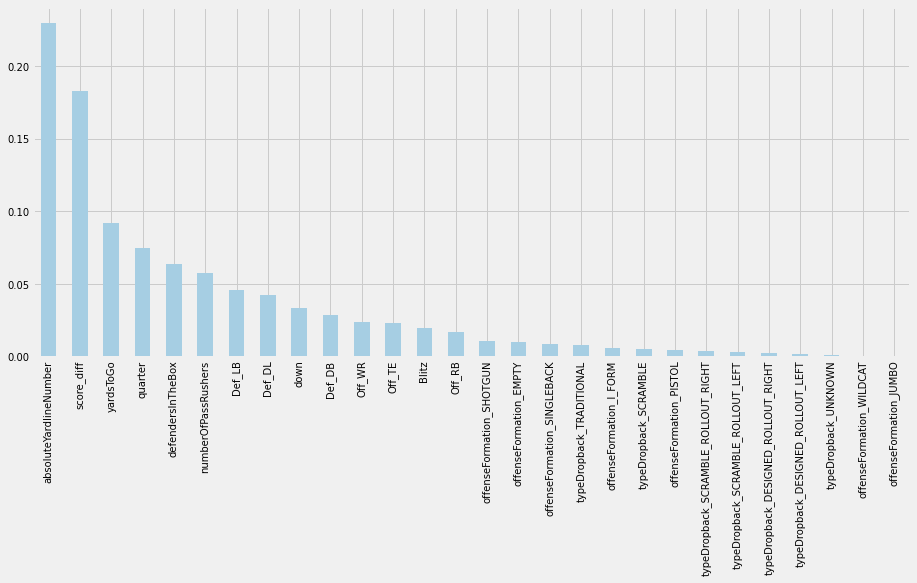

In [ ]:
# Print feature importance
pd.Series(play_result_model.feature_importances_,index = X.columns).sort_values(ascending = False).plot(kind = 'bar', figsize = (14,6))

In [ ]:
#data frame of the feature importance of each predictor in acsending order
predictors = pd.DataFrame(list(zip(X.columns,play_result_model.feature_importances_)),columns = ['predictor','feature importance']).sort_values(by='feature importance', ascending=False)
predictors

,predictor,feature importance
5,absoluteYardlineNumber,0.229485
13,score_diff,0.182525
2,yardsToGo,0.092254
0,quarter,0.074604
3,defendersInTheBox,0.064039
4,numberOfPassRushers,0.057359
11,Def_LB,0.045799
10,Def_DL,0.042142
1,down,0.033175
12,Def_DB,0.028681


In [ ]:
low_importance_features = predictors[predictors['feature importance'] < 0.01]['predictor'].tolist()

print(low_importance_features)

['offenseFormation_SINGLEBACK', 'typeDropback_TRADITIONAL', 'offenseFormation_I_FORM', 'typeDropback_SCRAMBLE', 'offenseFormation_PISTOL', 'typeDropback_SCRAMBLE_ROLLOUT_RIGHT', 'typeDropback_SCRAMBLE_ROLLOUT_LEFT', 'typeDropback_DESIGNED_ROLLOUT_RIGHT', 'typeDropback_DESIGNED_ROLLOUT_LEFT', 'typeDropback_UNKNOWN', 'offenseFormation_WILDCAT', 'offenseFormation_JUMBO']


## **1.6 Linear Regression**

In [ ]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()

lm_play_result_model = lm.fit(X_train,y_train)

y_test_pred_lm = lm_play_result_model.predict(X_test)

In [ ]:
lm_play_result_model.coef_

array([-1.79802259e-02, -5.18712933e-01,  5.79531458e-02, -2.80271322e-01,
       -1.11969953e-01,  3.09055942e-03, -4.45416256e-02,  9.60007592e-02,
        5.24994528e-01,  3.20833246e-01, -2.72601198e+00, -2.85676759e+00,
       -2.98862675e+00, -4.45869470e-03,  1.07455673e+00, -2.74764471e-01,
       -3.18696765e+00, -6.45536944e-01, -9.85807717e-01,  1.33993260e+00,
        2.67858744e+00,  8.63518176e+00,  1.09629652e+01,  5.78787578e+00,
        9.77776731e+00,  8.66519136e+00,  1.05312977e+01,  7.09753425e+00])

In [ ]:
predictors_lm = pd.DataFrame(list(zip(X.columns,lm_play_result_model.coef_)),columns = ['predictor','coef']).sort_values(by='coef', ascending=False)
predictors_lm

,predictor,coef
22,offenseFormation_I_FORM,10.962965
26,offenseFormation_SINGLEBACK,10.531298
24,offenseFormation_PISTOL,9.777767
25,offenseFormation_SHOTGUN,8.665191
21,offenseFormation_EMPTY,8.635182
27,offenseFormation_WILDCAT,7.097534
23,offenseFormation_JUMBO,5.787876
20,typeDropback_UNKNOWN,2.678587
19,typeDropback_TRADITIONAL,1.339933
14,typeDropback_DESIGNED_ROLLOUT_LEFT,1.074557


## **1.7 Linear Regression Model Evaluation**

In [ ]:
lm_mse = mean_squared_error(y_test, y_test_pred_lm)
lm_mse

105.93434234783615

## **1.8 Model Selection**

In [ ]:
X_1 = X.drop(['offenseFormation_SINGLEBACK', 'typeDropback_TRADITIONAL', 'offenseFormation_I_FORM', 'typeDropback_SCRAMBLE', 'offenseFormation_PISTOL', 'typeDropback_SCRAMBLE_ROLLOUT_RIGHT', 'typeDropback_SCRAMBLE_ROLLOUT_LEFT', 'typeDropback_DESIGNED_ROLLOUT_RIGHT', 'typeDropback_DESIGNED_ROLLOUT_LEFT', 'typeDropback_UNKNOWN', 'offenseFormation_WILDCAT', 'offenseFormation_JUMBO'], axis = 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size = 0.2, random_state = 42)

In [ ]:
random_forest_f = RandomForestRegressor( n_estimators = 100,max_features = 10,random_state = 42)

play_result_model_f = random_forest_f.fit(X_train,y_train)
y_test_pred = play_result_model_f.predict(X_test)

play_result_rf_f_mse = mean_squared_error(y_test, y_test_pred)
play_result_rf_f_mse

115.17722557320415

In [ ]:
lm_f = LinearRegression()

lm_play_result_model_f = lm_f.fit(X_train,y_train)

y_test_pred_lm = lm_play_result_model_f.predict(X_test)

In [ ]:
lm_mse_f = mean_squared_error(y_test, y_test_pred_lm)
lm_mse_f

106.64085588642878

# **2.0 Solution Presentation - Results**

## **2.1 Explainability of results**

In [ ]:
predictors.head(10)

,predictor,feature importance
5,absoluteYardlineNumber,0.229485
13,score_diff,0.182525
2,yardsToGo,0.092254
0,quarter,0.074604
3,defendersInTheBox,0.064039
4,numberOfPassRushers,0.057359
11,Def_LB,0.045799
10,Def_DL,0.042142
1,down,0.033175
12,Def_DB,0.028681


The results for the model were very explainable, with the place on the field being responsible for the amount ofyards available to gain on the play. In addition the difference in score typically allows for greater passing plays as defenses relax their coverages. Defenders in the box and the number of pass rushers increase the likelihood that the quarterback is tackled before throwing the ball.

In [ ]:
predictors_lm

,predictor,coef
22,offenseFormation_I_FORM,10.962965
26,offenseFormation_SINGLEBACK,10.531298
24,offenseFormation_PISTOL,9.777767
25,offenseFormation_SHOTGUN,8.665191
21,offenseFormation_EMPTY,8.635182
27,offenseFormation_WILDCAT,7.097534
23,offenseFormation_JUMBO,5.787876
20,typeDropback_UNKNOWN,2.678587
19,typeDropback_TRADITIONAL,1.339933
14,typeDropback_DESIGNED_ROLLOUT_LEFT,1.074557


The coefficients of the linear regression model were very explainable with the different types of drop backs such as "scramble" having negative coefficients. These plays occur when deffenders are openly chasing the quarterback and completing a pass becomes more difficult.

Additional offensive personell had positive coeffiecients and additional defensive personell had negative coefficients. Offesnsive players gain yards, and definsive players stop them. These values were very explainable.

## **2.2 Threats to validity**

In this model there was no data leakage so there is no threat to validity. However it could be said that it would be important to look at the players skill on the field and their respective positioning, this would be additional data to incorporate into a model to predict passing yards.

## **2.3 Conclusions**

In terms of a coaches mindset they can see which kind of formations and player personell have a relationship with the number of passing yards on a play. The defensive coaches would be looking to exploit the variables that have negative relationships with passing yards and offensive coaches would look to exploit variables with positive relationships

# **3.0 Causal Inference: The Impact of Blitzing on Passing Yards**

In this assignment I will look to see how the treatment of blitzing effects the number of passing yards(target) on a play in the NFL. A "Blitz" is when more than 4 of the 11 players on the defense rush the quarter back.

## **3.1 Introduction to Causal Inference**

Causal inference is a statistical approach used to determine the cause-and-effect relationship between a treatment and an outcome. In the context of NFL games, causal inference can be applied to analyze how specific defensive strategies, such as blitzing the quarterback, affect the number of passing yards achieved in a play. Blitzing, which involves sending more than 4 players  to rush the quarterback, is a critical factor that can disrupt the offensive team's plans, potentially leading to significant changes in play outcomes.


Understanding the causal impact of blitzing on passing yards is essential for predicting play outcomes, strategizing defensive plays, and evaluating the effectiveness of different defensive tactics. By employing causal inference methods, we can isolate the effect of blitzing from other confounding factors, providing insights into its true impact on passing yards. This knowledge is invaluable for coaches making strategic decisions, bettors assessing game odds, and teams preparing for opponents, as it helps predict how certain defensive actions will influence the game's flow and outcome.







## **3.2 Defining the Problem**

In our analysis, the treatment is the act of blitzing the quarterback, operationalized by observing whether more than four defenders rush the quarterback during a play. The target outcome is the number of passing yards achieved on a play, which we aim to predict based on the presence or absence of blitzing.

Control Features include aspects of the game situation and team formation that could influence the outcome independently of the treatment. These features are:

- Game situation variables: `quarter`, `down`, `yardsToGo`, `absoluteYardlineNumber`, `score_diff`.

- Team formation and play type variables: `defendersInTheBox`, `numberOfPassRushers`, `Off_RB`, `Off_TE`, `Off_WR`, `Def_DL`, `Def_LB`, `Def_DB`, and variables indicating the type of dropback and offense formation.

- The Treatment Feature is implicitly defined by the act of blitzing where the `numberOfPassRushers` (with more than four indicating a blitz), this is stored in a Binary variable `Blitz` with 1 representing a blitz and 0 otherwise.

We hypothesize that blitzing affects the target outcome (passing yards) by increasing pressure on the quarterback, potentially leading to more hurried throws, sacks, or plays where the quarterback must scramble, thereby impacting the efficiency and effectiveness of passing plays. Understanding this causal relationship is crucial for both offensive and defensive strategy formulation in the NFL.

## **3.3 Data Preparation for Causal Analysis**

In [ ]:
plays.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18584 entries, 0 to 18605
Data columns (total 30 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   quarter                              18584 non-null  int64  
 1   down                                 18584 non-null  int64  
 2   yardsToGo                            18584 non-null  int64  
 3   possessionTeam                       18584 non-null  object 
 4   defendersInTheBox                    18584 non-null  float64
 5   numberOfPassRushers                  18584 non-null  float64
 6   absoluteYardlineNumber               18584 non-null  float64
 7   offensePlayResult                    18584 non-null  int64  
 8   Blitz                                18584 non-null  int64  
 9   Off_RB                               18584 non-null  int64  
 10  Off_TE                               18584 non-null  int64  
 11  Off_WR                      

In [ ]:
#target

y

0        10
1         0
2         0
3        33
4         0
         ..
18601     7
18602    17
18603     0
18604     0
18605     0
Name: offensePlayResult, Length: 18584, dtype: int64

In [ ]:
# control features

X_2 = X.drop(['Blitz'],axis=1)

X_2


,quarter,down,yardsToGo,defendersInTheBox,numberOfPassRushers,absoluteYardlineNumber,Off_RB,Off_TE,Off_WR,Def_DL,...,typeDropback_SCRAMBLE_ROLLOUT_RIGHT,typeDropback_TRADITIONAL,typeDropback_UNKNOWN,offenseFormation_EMPTY,offenseFormation_I_FORM,offenseFormation_JUMBO,offenseFormation_PISTOL,offenseFormation_SHOTGUN,offenseFormation_SINGLEBACK,offenseFormation_WILDCAT
0,1,1,15,7.0,4.0,90.0,2,1,2,4,...,0,1,0,0,1,0,0,0,0,0
1,1,1,10,7.0,4.0,49.0,1,1,3,4,...,0,1,0,0,0,0,0,0,1,0
2,1,2,10,6.0,4.0,49.0,2,1,2,4,...,0,1,0,0,0,0,0,1,0,0
3,1,3,10,6.0,5.0,49.0,1,1,3,4,...,0,0,0,0,0,0,0,1,0,0
4,1,3,1,8.0,6.0,11.0,2,3,0,6,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18601,4,2,2,6.0,4.0,77.0,1,1,3,1,...,0,1,0,0,0,0,0,1,0,0
18602,4,1,10,4.0,5.0,70.0,1,1,3,1,...,0,1,0,0,0,0,0,1,0,0
18603,4,1,10,5.0,5.0,53.0,1,1,3,1,...,0,1,0,0,0,0,0,1,0,0
18604,4,2,10,4.0,4.0,53.0,1,1,3,1,...,0,1,0,0,0,0,0,1,0,0


In [ ]:
#treatment

treatment = X['Blitz']
treatment

0        0
1        0
2        0
3        1
4        1
        ..
18601    0
18602    1
18603    1
18604    0
18605    0
Name: Blitz, Length: 18584, dtype: int64

In [ ]:
cols_s = X_2.columns.tolist()
cols_s

['quarter',
 'down',
 'yardsToGo',
 'defendersInTheBox',
 'numberOfPassRushers',
 'absoluteYardlineNumber',
 'Off_RB',
 'Off_TE',
 'Off_WR',
 'Def_DL',
 'Def_LB',
 'Def_DB',
 'score_diff',
 'typeDropback_DESIGNED_ROLLOUT_LEFT',
 'typeDropback_DESIGNED_ROLLOUT_RIGHT',
 'typeDropback_SCRAMBLE',
 'typeDropback_SCRAMBLE_ROLLOUT_LEFT',
 'typeDropback_SCRAMBLE_ROLLOUT_RIGHT',
 'typeDropback_TRADITIONAL',
 'typeDropback_UNKNOWN',
 'offenseFormation_EMPTY',
 'offenseFormation_I_FORM',
 'offenseFormation_JUMBO',
 'offenseFormation_PISTOL',
 'offenseFormation_SHOTGUN',
 'offenseFormation_SINGLEBACK',
 'offenseFormation_WILDCAT']

## **3.4 Methodology Overview**

In our causal inference analysis, we employ a variety of models and techniques to understand the impact of blitzing on passing yards. The choice of multiple models, including LRSRegressor, XGBT Regressor, and LGBMRegressor, is strategic, designed to leverage the unique strengths of each approach for a comprehensive understanding of causal effects.

- LGBMRegressor: Used for its robustness in handling a wide range of data types and its ability to capture complex relationships between features. It serves as the base algorithm for the S Learner, a meta-learner framework that models the treatment effect directly.
- S Learner: A causal inference model that combines the
- LGBMRegressor to estimate the Average Treatment Effect (ATE) of blitzing. It provides a holistic view by considering the entire dataset to determine the overall impact of the treatment.
- LRSRegressor: A linear regression model that estimates the ATE, offering insights into the linear relationship between the treatment and outcome. It helps in understanding the direct impact of blitzing under simpler assumptions.
- XGBT Regressor: Utilizes the XGBoost framework for gradient boosting, known for its efficiency and accuracy in regression tasks. It complements the analysis by assessing the treatment effect through another lens, potentially capturing nonlinearities missed by other models.

These models contribute to the analysis in the following ways:

- Comprehensive Insights: By employing multiple models, we can capture both linear and nonlinear relationships between blitzing and passing yards, ensuring a well-rounded understanding.
- Robustness Check: Using various models serves as a robustness check, validating the consistency of our findings across different analytical frameworks.
- Model-Specific Insights: Each model provides unique insights, such as feature importance rankings and SHAP values, that help in interpreting the causal effect of blitzing on passing yards.

The methodology also includes assessing feature importance to identify which aspects most significantly impact passing yards when blitzing occurs. This analysis is vital for both offensive and defensive strategizing in the NFL, offering nuanced insights into how blitzing influences play outcomes and informing more effective play-calling decisions.

## **3.5 S Learner**

In [ ]:
# specify model for model_tau
model_tau = LGBMRegressor(importance_type=' Gain')

# specify control_name
treatment_multi = np.array(['Blitz' if x==1 else 'control' for x in treatment])

# create the S Learner
base_algo = LGBMRegressor()
slearner = BaseSRegressor(base_algo, control_name='control')

# estimate the ATE
slearner.estimate_ate(X_2, treatment_multi, y)

# fit and predict
slearner_tau = slearner.fit_predict(X_2, treatment_multi, y)

# get feature importance
slearner.get_importance(X=X_2,
                        tau=slearner_tau,
                        normalize=True,
                        method='auto',
                        features=cols_s)




{'Blitz': typeDropback_SCRAMBLE                  0.179899
 score_diff                             0.179058
 absoluteYardlineNumber                 0.130405
 offenseFormation_SHOTGUN               0.091587
 yardsToGo                              0.079761
 defendersInTheBox                      0.060855
 down                                   0.055297
 Def_LB                                 0.049406
 quarter                                0.043368
 Off_TE                                 0.029643
 typeDropback_TRADITIONAL               0.028645
 Def_DB                                 0.019746
 Off_WR                                 0.010286
 offenseFormation_SINGLEBACK            0.009189
 offenseFormation_I_FORM                0.008263
 Def_DL                                 0.007754
 offenseFormation_EMPTY                 0.005624
 Off_RB                                 0.005422
 numberOfPassRushers                    0.003118
 offenseFormation_PISTOL                0.001361
 typeDropba

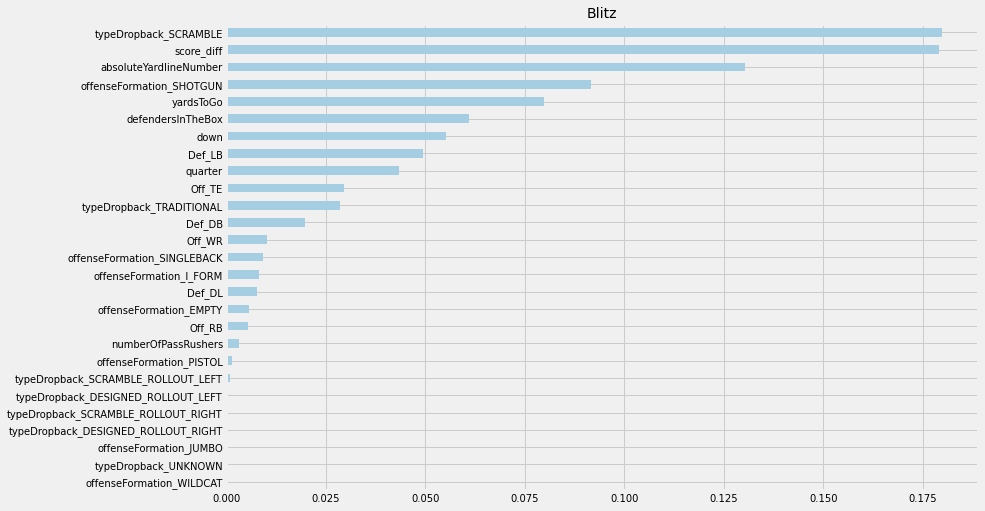

In [ ]:
slearner.plot_importance(X=X_2,
                        tau=slearner_tau,
                        normalize=True,
                        method='auto',
                        features=cols_s)

The treatment of "Blitzing" the quarterback has the greatest effect on passing yards when the quarteback has to scramble away from defenders, and is more common when the offense is in the shotgun (a commonly used passing formation) and when there are more yard to go to get a first down. The increased yardage to get a first down indicates a pass to the defense since it is harder to gain the yaradge by running.

In [ ]:
slearner.get_importance(X=X_2,
                        tau=slearner_tau,
                        normalize=True,
                        method='permutation',
                        features=cols_s)

{'Blitz': score_diff                             0.515999
 typeDropback_SCRAMBLE                  0.338864
 absoluteYardlineNumber                 0.224968
 defendersInTheBox                      0.192924
 yardsToGo                              0.157697
 down                                   0.136595
 offenseFormation_SHOTGUN               0.121907
 quarter                                0.102912
 Off_TE                                 0.100677
 Def_LB                                 0.076559
 typeDropback_TRADITIONAL               0.070983
 Def_DB                                 0.033953
 Def_DL                                 0.022631
 offenseFormation_I_FORM                0.017459
 offenseFormation_SINGLEBACK            0.014080
 Off_WR                                 0.014013
 offenseFormation_EMPTY                 0.012134
 Off_RB                                 0.006104
 offenseFormation_PISTOL                0.003417
 numberOfPassRushers                    0.001162
 typeDropba

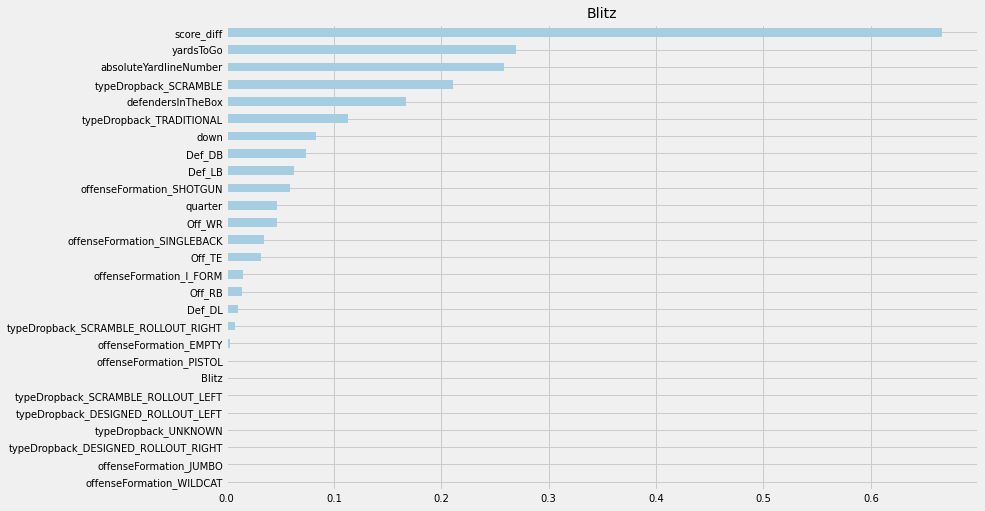

In [ ]:
slearner.plot_importance(X=X_2,
                        tau=slearner_tau,
                        normalize=True,
                        method='permutation',
                        features=cols_s)

In [ ]:
shap_slearner = slearner.get_shap_values(X=X_2, tau=slearner_tau)
shap_slearner

{'Blitz': array([[ 8.33440942e-02,  1.09585757e-01, -3.56898926e-01, ...,
          6.82675825e-02, -2.01802434e-04,  0.00000000e+00],
        [ 4.54807769e-02,  8.62241526e-02,  5.74741053e-02, ...,
          6.60445391e-02, -1.88777084e-03,  0.00000000e+00],
        [ 2.10067085e-02,  5.32955401e-02,  4.20245231e-02, ...,
         -3.46460866e-02,  1.76692255e-03,  0.00000000e+00],
        ...,
        [-1.44062216e-01,  8.98322066e-03,  6.71539276e-02, ...,
         -4.51051288e-02,  2.74690144e-03,  0.00000000e+00],
        [-1.23225497e-01, -3.15341932e-03,  6.80590867e-02, ...,
         -2.90255513e-02,  2.79596205e-03,  0.00000000e+00],
        [-5.95818001e-02, -2.06522131e-02, -1.29922966e-01, ...,
         -2.05381081e-02,  2.48455437e-03,  0.00000000e+00]])}

In [ ]:
np.mean(np.abs(shap_slearner['Blitz']),axis=0)

array([0.05760299, 0.10909275, 0.10652304, 0.07188077, 0.00321718,
       0.11366935, 0.00734358, 0.08129665, 0.01187069, 0.03252256,
       0.08513194, 0.03145419, 0.18886372, 0.00119805, 0.        ,
       0.12974808, 0.00156786, 0.00062809, 0.05670988, 0.        ,
       0.00872328, 0.01977372, 0.        , 0.00467911, 0.067827  ,
       0.01037406, 0.        ])

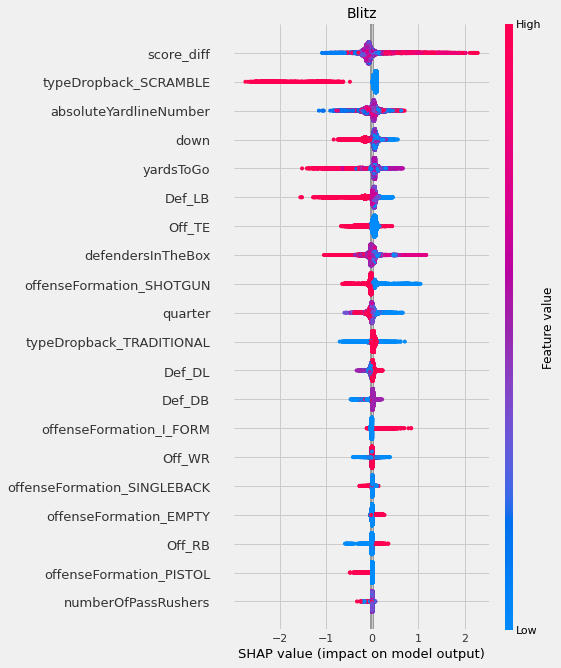

In [ ]:
# Plot shap values without specifying shap_dict
slearner.plot_shap_values(X=X_2, tau=slearner_tau, features=cols_s)

The three features that have the most distinct relationships are score_diff, scramble and yard to go. With score difference it demonstrates that as the difference increases the team that is losing the game is more likely to take chances to gain passing yards.

Scrambling is caused by defenders chasing the quarterback and can be said to be caused by defenders that have blitzed and suprised their opponent.

Yards to go has a negative impact on the passing yards as when this increases the defense knows you are more likely to pass and can prepare for a pass by including more pass heavy deffenders or by blitzing.

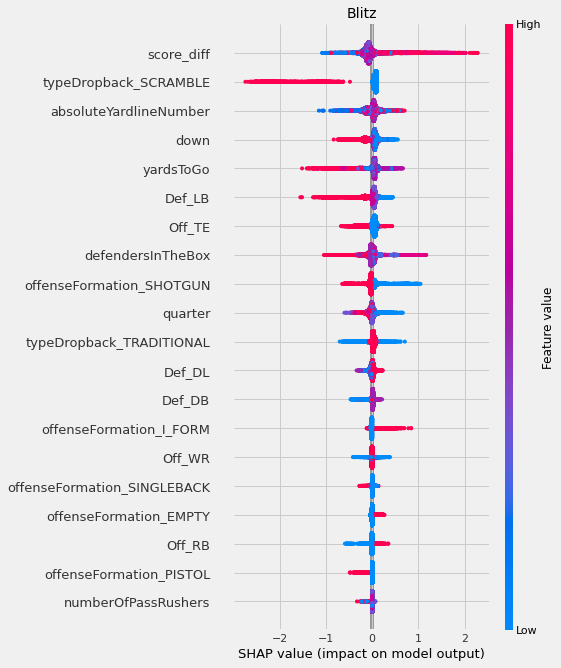

In [ ]:
# Plot shap values WITH specifying shap_dict
slearner.plot_shap_values(X=X_2, shap_dict=shap_slearner, features = cols_s)

## **3.6. LRS Regressor**

In [ ]:
learner_s = LRSRegressor()
ate_s = learner_s.estimate_ate(X=X_2, treatment=treatment, y=y)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

# After calling estimate_ate, add pretrain=True flag to skip training
# This flag is applicable for other meta learner
ate_s = learner_s.estimate_ate(X=X_2, treatment=treatment, y=y, pretrain=True)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

(array([-0.27320279]), array([-0.80113277]), array([0.25472719]))
ATE estimate: -0.273
ATE lower bound: -0.801
ATE upper bound: 0.255
(array([-0.27320279]), array([-0.80113277]), array([0.25472719]))
ATE estimate: -0.273
ATE lower bound: -0.801
ATE upper bound: 0.255


The results above show the estimated average treatment effect of the treatment (blitzing) on the target (passing yards) using the LRSRegressor model.

The ATE estimate is -0.273, which means that on average, the passing yards decreased by 0.273 yards when the defense blitzed compared to when they didn't.

The lower and upper bounds of the ATE are -0.801 and 0.255 respectively. These represent the 95% confidence interval of the ATE estimate. It means that with 95% confidence, the true ATE falls between -0.801 and 0.255 yards.

## **3.7 LightGBM**

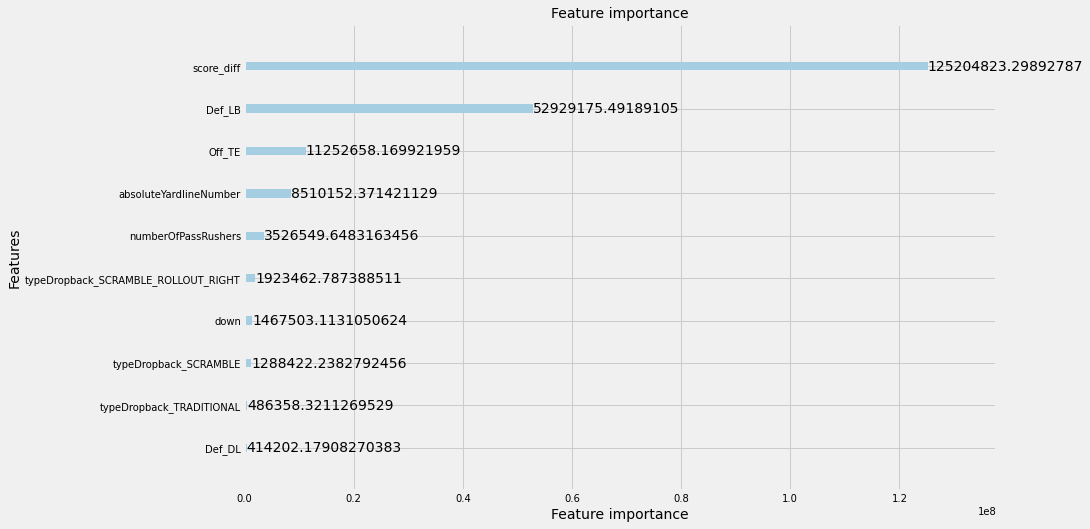

In [ ]:
import lightgbm as lgb
# Get feature importances
lgb_model = LGBMRegressor()
lgb_model.fit(X,treatment, y)

# Plot the feature importances
lgb.plot_importance(lgb_model, importance_type='gain', max_num_features=10)


## **3.8 T-Learner Models**

In [ ]:
# Ready-to-use T-Learner using XGB
learner_t = XGBTRegressor()
ate_t = learner_t.estimate_ate(X=X_2, treatment=treatment, y=y)
print('Using the ready-to-use XGBTRegressor class')
print(ate_t)

# Calling the Base Learner class and feeding in XGB
learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X=X_2, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using XGB (same result):')
print(ate_t)

# Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTRegressor(learner=LinearRegression())
ate_t = learner_t.estimate_ate(X=X_2, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using Linear Regression (different result):')
print(ate_t)

[02:12:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:12:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Using the ready-to-use XGBTRegressor class
(array([-0.32282905]), array([-0.65483973]), array([0.00918163]))
[02:12:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:12:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Using the BaseTRegressor class and using XGB (same result):
(array([-0.32282905]), array([-0.65483973]), array([0.00918163]))

Using the BaseTRegressor class and using Linear Regression (different result):
(array([0.0100153]), array([-0.33184146]), array([0.35187205]))




The XGBTRegressor and BaseTRegressor with XGBRegressor both produce the same result, with an ATE estimate of -0.323, a lower bound of -0.655, and an upper bound of 0.009. This indicates that, on average, blitzing is estimated to have a negative impact of -0.323 passing yards on the outcome.

The BaseTRegressor with LinearRegression produces a different result, with an ATE estimate of 0.01, a lower bound of -0.332, and an upper bound of 0.352. This indicates that, on average, blitzing is estimated to have a positive impact of 0.01 passing yards on the outcome. The lower and upper bounds indicate the uncertainty around this estimate.

## **3.9 Conclusion to Causal Inference Analysis**

Through causal inference analysis, we explored the impact of blitzing on passing yards in NFL plays. Leveraging a variety of models, including the S Learner, LRSRegressor, and T-Learner models with LightGBM and XGBoost, we sought to isolate the effect of blitzing from other factors influencing play outcomes. This comprehensive approach has yielded valuable insights into defensive strategies and their implications on game dynamics.

**Key Takeaways:**

- **Blitzing's Varied Impact:** The analysis revealed that blitzing significantly affects passing yards, particularly when the quarterback is forced to scramble. This suggests that the strategic use of blitzing can disrupt passing plays, but its effectiveness is contingent upon the offensive formation and the situation on the field.
- **Model-Specific Insights:** Different models provided nuanced understandings of blitzing's impact. For instance, the LRSRegressor indicated a general decrease in passing yards due to blitzing, while the T-Learner models offered a more detailed view of the conditions under which blitzing is most effective.
- **Feature Importance and Strategic Implications:** Feature importance analysis highlighted key factors that mediate the effect of blitzing, such as the type of offensive formation and the yards to go for a first down. These insights are invaluable for teams in preparing defensive strategies that maximize the potential of blitzing to disrupt the opponent's offensive plays.

This causal inference study underscores the complexity of NFL play outcomes and the strategic depth of defensive play-calling. By understanding the causal impact of blitzing, teams can refine their defensive tactics, while analysts can more accurately predict play outcomes in varying game situations.





